In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/gsdavis1959/Data/master/hotel_bookings.csv')\
    .rename(columns={'arrival_date_year':'year','arrival_date_month':'month',
                     'arrival_date_day_of_month':'day'})

def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9,
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]

df['month'] = df['month'].apply(monthToNum)
df['date']= pd.to_datetime(df[["year", "month", "day"]])

#fileter data for resort hotel and remove cancelations
df = df[(df['is_canceled']==0) & (df['hotel']=='Resort Hotel')]
t_df = df.groupby(['date'])['hotel'].count().reset_index()\
         .rename(columns={'hotel':'y','date':'ds'})

In [2]:
import plotly.express as px

fig = px.line(t_df, x="ds", y="y", title='hotel demands')
fig.show()

Method 4: Pick-up
Pick-up models are popular in the hotel industry because they leverage the unique attributes of reservations throughout the booking window. These models effectively utilize reserved booking data, setting them apart from other methods discussed earlier.

In this analysis, we illustrate the additive pick-up approach, where the final demand forecast is calculated as the sum of current bookings and the average pick-up between the present day and the target day. Alternatively, you can also use the multiplicative approach, which assumes that current bookings are proportional to the final arrivals.

Key terms related to additive pick-up models are as follows:

Booking lead time: The number of days between a specific date and the arrival date.

On-the-books reservations: Reserved bookings present for a particular date.

Number picked up: Additional reservations received from the current date until the arrival date. The historical average of this value is known as the average pick-up.

Pick-up forecast: The sum of on-the-books reservations and the average pick-up.

For example, on March 1st, 2022, there are 350 on-the-books reservations for April 1st, and the final reservations on April 1st amount to 450. The booking lead time in this case is 31 days, resulting in an average pick-up of 100 over that period. On March 1st, 2023, there are 300 on-the-books reservations for April 1st, 2023. Therefore, the forecast for March 1st, 2023, is 400 (300 reservations + 100 pick-up).

In [4]:
import numpy as np
#treat all bookings 365 days ago as 365 days
df['lead_time2'] = np.where(df["lead_time"] >365,365, df["lead_time"])

train_matrix = df.loc[df['date']<'2017-08-01']\
                 .groupby(['date','lead_time2'])['hotel'].count().reset_index()
train_matrix = train_matrix.sort_values(['date', 'lead_time2'],
                                          ascending=[True, False])

train_matrix['bookings_cumsum'] = train_matrix.groupby(['date'])['hotel']\
                                              .transform(pd.Series.cumsum)
train_matrix = train_matrix.rename(columns={'hotel':'bookings'})
train_matrix

,date,lead_time2,bookings,bookings_cumsum
27,2015-07-01,365,1,1
26,2015-07-01,342,1,2
25,2015-07-01,181,1,3
24,2015-07-01,149,2,5
23,2015-07-01,145,1,6
...,...,...,...,...
15201,2017-07-31,23,1,28
15200,2017-07-31,22,2,30
15199,2017-07-31,5,1,31
15198,2017-07-31,1,2,33


In [9]:
date_index = df.groupby("date")['hotel'].count().reset_index()
date_index['max'] = 365
date_index['min'] = 0
date_index = date_index.loc[date_index.index.repeat(date_index['max']\
                                        .sub(date_index['min']) + 1)]
date_index['lead_time'] = date_index['min'].add(date_index.groupby(level=0)\
                                           .cumcount())
date_index = date_index.drop(columns=['hotel','max','min'])
date_index = date_index.sort_values(['date', 'lead_time'], ascending=[True, False])

In [12]:
date_index.columns

Index(['date', 'lead_time'], dtype='object')

In [14]:
train_pickup_df = date_index.merge(train_matrix, left_on=['date','lead_time'], \
                                right_on=['date','lead_time2'], how='left')\
                             .rename(columns={'hotel':'bookings'})

train_pickup_df['bookings_cumsum2']= train_pickup_df.groupby('date')\
                                      ['bookings_cumsum'].ffill()
train_pickup_df['bookings_cumsum2']= train_pickup_df['bookings_cumsum2']\
                                     .fillna(0)
train_pickup_df

,date,lead_time,lead_time2,bookings,bookings_cumsum,bookings_cumsum2
0,2015-07-01,365,365.0,1.0,1.0,1.0
1,2015-07-01,364,NaN,NaN,NaN,1.0
2,2015-07-01,363,NaN,NaN,NaN,1.0
3,2015-07-01,362,NaN,NaN,NaN,1.0
4,2015-07-01,361,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...
290233,2017-08-31,4,NaN,NaN,NaN,0.0
290234,2017-08-31,3,NaN,NaN,NaN,0.0
290235,2017-08-31,2,NaN,NaN,NaN,0.0
290236,2017-08-31,1,NaN,NaN,NaN,0.0


In [16]:
total =  df.groupby("date")['hotel'].count().reset_index()
roh = train_pickup_df[['date','lead_time','bookings_cumsum2']]\
            .merge(total, left_on=['date'], right_on=['date'], how='inner')
roh['pickup'] = roh['hotel'] - roh['bookings_cumsum2']
lookup = roh.loc[roh['date']<'2017-08-01'].groupby('lead_time')\
                              ['pickup'].mean().round().reset_index()
lookup

,lead_time,pickup
0,0,0.0
1,1,4.0
2,2,6.0
3,3,7.0
4,4,8.0
...,...,...
361,361,36.0
362,362,36.0
363,363,36.0
364,364,36.0


In [17]:
test_matrix = df.loc[df['date']>='2017-08-01']\
             .groupby(['date','lead_time2'])['hotel'].count().reset_index()
test_matrix = test_matrix.sort_values(['date', 'lead_time2']\
                                      , ascending=[True, False])
test_matrix['bookings_cumsum'] = test_matrix.groupby(['date'])['hotel']\
                                           .transform(pd.Series.cumsum)
test_matrix['bookdate'] = test_matrix['date'] \
                       - pd.to_timedelta(test_matrix['lead_time2'], unit='D')
test =test_matrix.loc[test_matrix['bookdate']<'2017-08-01']\
                  .rename(columns={'hotel':''})


In [22]:
last= test.groupby('date')['lead_time2'].min().reset_index()
pickup = test.merge(last, left_on=['date','lead_time2'],\
                    right_on=['date','lead_time2'], how='inner')\
    .merge(lookup, left_on=['lead_time2'], right_on=['lead_time'], how='inner')

pickup['pickup_forecast'] = pickup['bookings_cumsum'] + pickup['pickup']
pcikup_forecast = pickup[['date','pickup_forecast']].merge(total,\
                                 left_on='date', right_on='date')
pcikup_forecast = pcikup_forecast.rename(columns={'hotel':'y'})
pcikup_forecast

,date,pickup_forecast,y
0,2017-08-01,54.0,46
1,2017-08-04,36.0,37
2,2017-08-02,36.0,29
3,2017-08-06,44.0,43
4,2017-08-03,34.0,28
5,2017-08-05,42.0,38
6,2017-08-10,34.0,29
7,2017-08-07,57.0,48
8,2017-08-08,49.0,38
9,2017-08-16,46.0,38


In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Bookings')

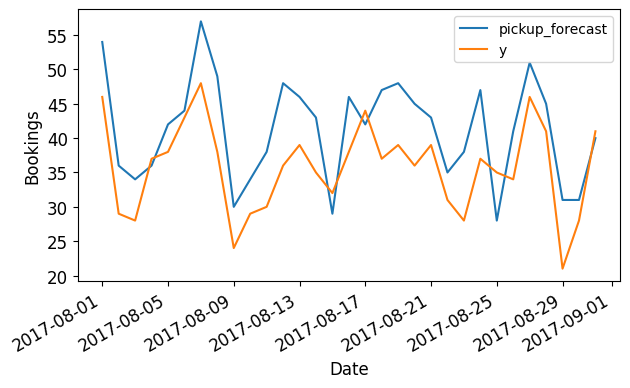

In [23]:
pcikup_forecast = pcikup_forecast.set_index('date')
pcikup_forecast.plot(figsize=(7,4),fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)

In [24]:
from sklearn.metrics import mean_absolute_error
print('Time Series: {:.0f}'.format(mean_absolute_error(
            pcikup_forecast[['pickup_forecast']], pcikup_forecast[['y']])))

Time Series: 6


In [26]:
train_df = t_df.loc[(t_df['ds']>='2015-07-01') & (t_df['ds']<'2017-08-01')]
test_df = t_df.loc[(t_df['ds']>='2017-08-01') & (t_df['ds']<'2017-09-01')]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdi4fr9aw/09vedj1r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdi4fr9aw/47etyqnd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=571', 'data', 'file=/tmp/tmpdi4fr9aw/09vedj1r.json', 'init=/tmp/tmpdi4fr9aw/47etyqnd.json', 'output', 'file=/tmp/tmpdi4fr9aw/prophet_modelbi2r9_4_/prophet_model-20240106173338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:33:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:33:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


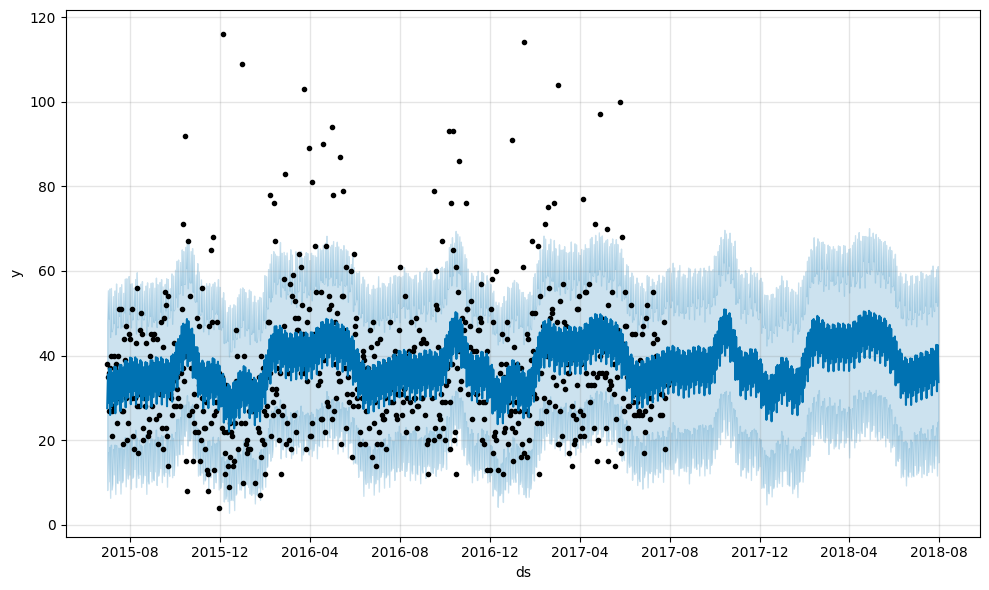

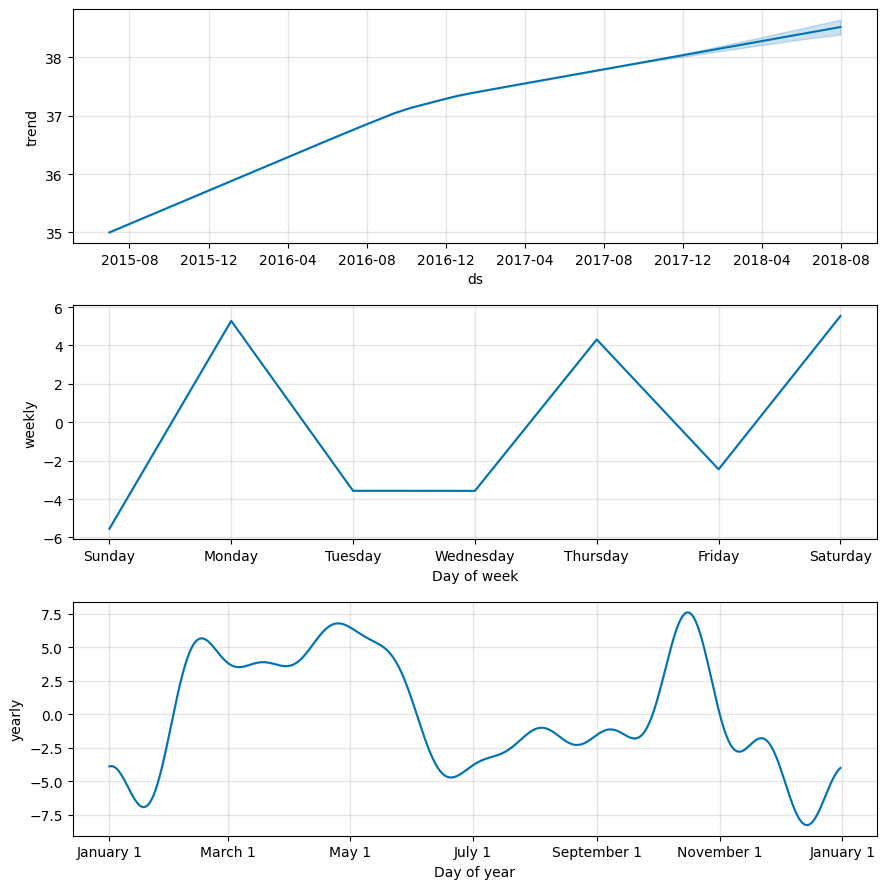

In [30]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

train_df_prophet = train_df.copy()
model = Prophet(weekly_seasonality=True)
model.fit(train_df_prophet)
forecast = model.make_future_dataframe(periods=365)
pred = model.predict(forecast)

#plots
prophet_plot = model.plot(pred)
prophet_plot2 = model.plot_components(pred)

Text(0, 0.5, 'Bookings')

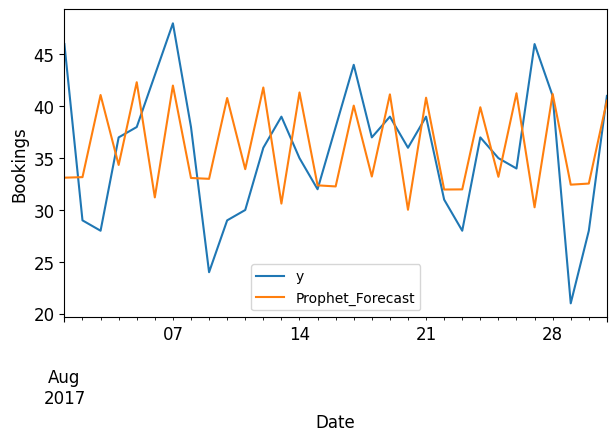

In [28]:
forecast_df = test_df.merge(pred,left_on='ds', right_on='ds', how='inner')\
.rename(columns={'yhat':'Prophet_Forecast'})

test_output_viz = forecast_df[['ds','y','Prophet_Forecast']]
test_output_viz= test_output_viz.set_index('ds')

test_output_viz.plot.line(figsize=(7,4),fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bookings', fontsize=12)